# Анализ и визуализация телеметрии самосвалов
В этом ноутбуке загружается предобработанный датасет `telemetry_filtered_filled.csv` и строятся графики для анализа поведения техники (распределения, корреляции, простои и временные ряды).

In [ ]:
import os

import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

In [ ]:
def setup_pandas_options():
    """Настройка глобальных опций pandas для отображения."""
    pd.set_option("display.precision", 3)
    pd.set_option("expand_frame_repr", False)

setup_pandas_options()

In [1]:
source_root = '../dataset'
filtered_data_path = os.path.join(source_root, 'telemetry_filtered_filled.csv')
filtered_data = pd.read_csv(filtered_data_path)
print(f'Потребление памяти после оптимизации:')
print(filtered_data.info(memory_usage='deep'))
print('\nПервые строки датасета:')
print(filtered_data.head())
print('\nРазмер датасета:', filtered_data.shape)
print('\nПроверка на пропуски в данных:')
print(filtered_data.isnull().sum())
print('\nСтатистическое описание данных:')
print(filtered_data.describe())

Потребление памяти после оптимизации:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 53512194 entries, 0 to 53512193
Data columns (total 23 columns):
 #   Column                     Dtype  
---  ------                     -----  
 0   create_dt                  object 
 1   mdm_object_id              int64  
 2   mdm_object_name            int64  
 3   alt                        float64
 4   speed_gps                  float64
 5   inst_fuel                  float64
 6   weight                     float64
 7   temp_engine                float64
 8   turn_engine                float64
 9   load_engine                float64
 10  pres_coolant_nn            float64
 11  pres_rail_injector_nn      float64
 12  pres_temp_engine_nn        float64
 13  torque_nn                  float64
 14  pres_des_rail_injector_nn  float64
 15  dynamic_brake              float64
 16  mdm_object_uuid            object 
 17  meta_object_name           int64  
 18  mdm_model_name             object 
 19  df

## Общая информация по объектам и моделям

In [2]:
print('\nРаспределение по уникальным объектам (самосвалам):')
print(filtered_data['mdm_object_id'].value_counts())
print('\nКоличество уникальных моделей:')
print(filtered_data['mdm_object_name'].nunique())
print('\nСписок уникальных моделей:')
print(filtered_data['mdm_object_name'].unique())


Распределение по уникальным объектам (самосвалам):
mdm_object_id
1661     12417997
1581     12181919
1381     10418580
21186     7383740
1383      5863776
1384      5246182
Name: count, dtype: int64

Количество уникальных моделей:
6

Список уникальных моделей:
[1395 1349 1381 1497 1374 1385]


## Базовая фильтрация и новые признаки
- Оставляем только записи с положительной температурой двигателя.
- Ограничиваем скорость сверху (например, < 200 км/ч).
- Добавляем бинарный флаг `is_stopped` (самосвал стоял, если `speed_gps == 0`).

In [3]:
print('Оставим только температуру двигателя > 0..')
filtered_data = filtered_data[filtered_data['temp_engine'] > 0]
print(filtered_data.shape)

print('Оставим только разумные значения скорости (например, < 200 км/ч)..')
filtered_data = filtered_data[filtered_data['speed_gps'] < 200]
filtered_data['is_stopped'] = (filtered_data['speed_gps'] == 0).astype(int)
print(filtered_data.shape)

Оставим только температуру двигателя > 0..
(43751921, 23)
Оставим только разумные значения скорости (например, < 200 км/ч)..
(43751198, 24)


## Корреляционный анализ
Считаем корреляционную матрицу по числовым признакам, строим тепловую карту и выделяем пары признаков с сильной корреляцией по модулю > 0.6.


Корреляционная матрица:
                           mdm_object_id  mdm_object_name    alt  speed_gps  inst_fuel  weight  temp_engine  turn_engine  load_engine  pres_coolant_nn  pres_rail_injector_nn  pres_temp_engine_nn  torque_nn  pres_des_rail_injector_nn  dynamic_brake  meta_object_name  dfm_in_hour  dfm_out_sum  dfm_out_hour  is_stopped
mdm_object_id                      1.000            0.942  0.004      0.008     -0.015  -0.009       -0.108       -0.024   -1.687e-02           -0.028                 -0.007                0.141     -0.017                 -1.137e-02          0.072             0.942       -0.133       -0.130        -0.133      -0.003
mdm_object_name                    0.942            1.000 -0.019      0.016     -0.017  -0.012       -0.045       -0.022   -2.038e-02           -0.033                 -0.005                0.226     -0.020                 -6.509e-03          0.049             1.000       -0.135       -0.132        -0.135      -0.014
alt                  

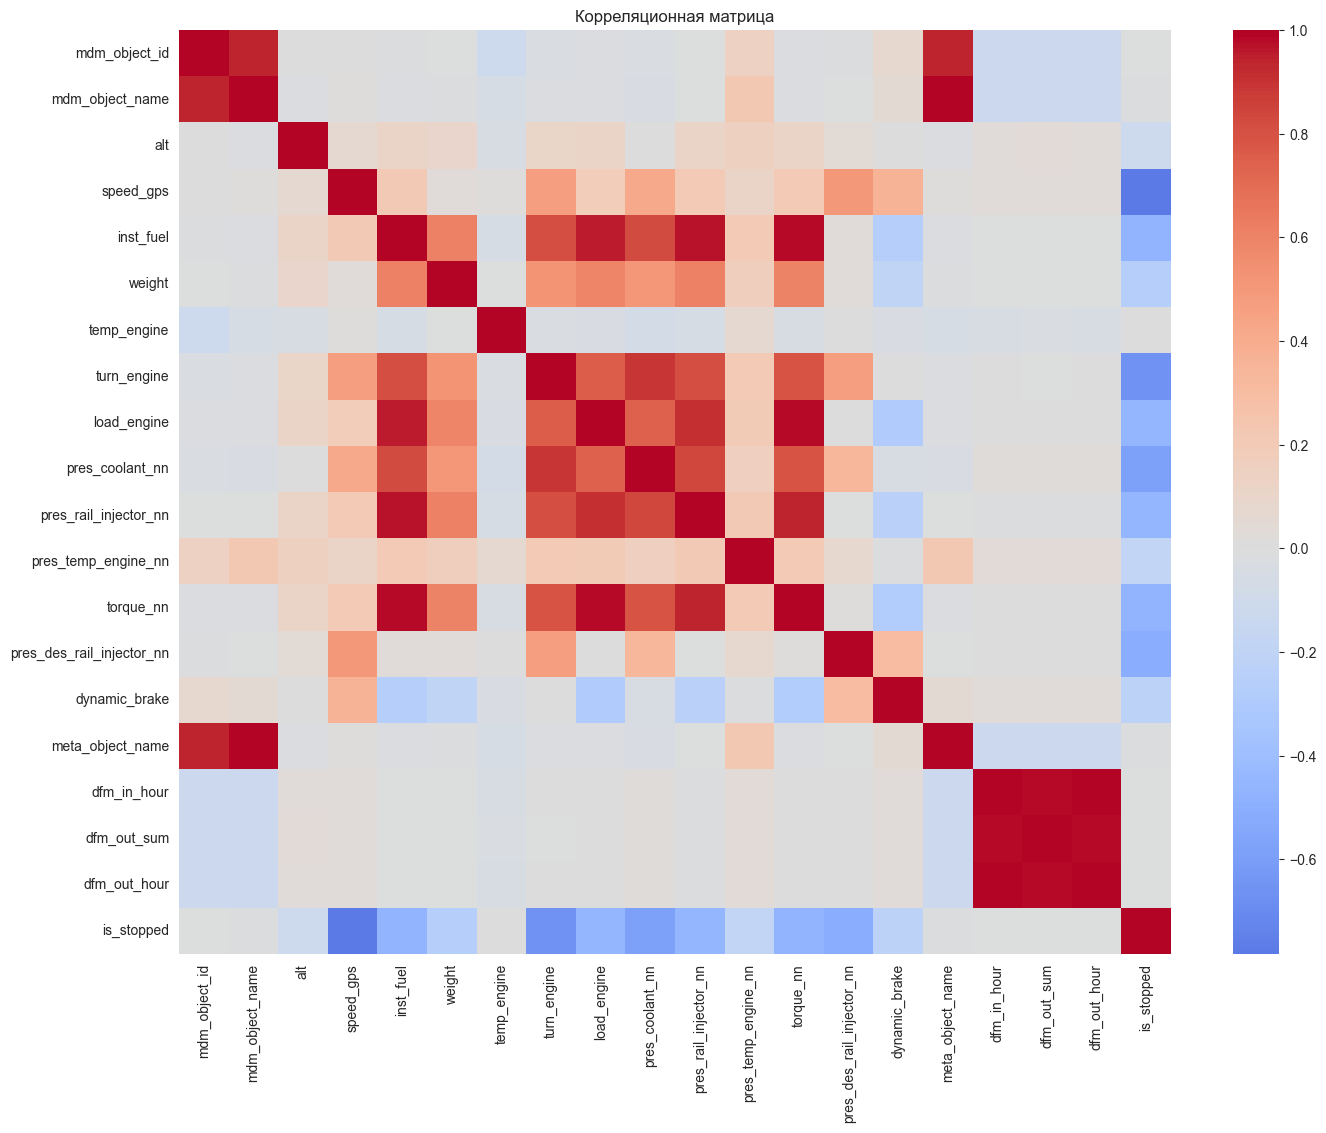


Пары с сильной корреляцией:
                       mdm_object_id  mdm_object_name  speed_gps  inst_fuel  weight  turn_engine  load_engine  pres_coolant_nn  pres_rail_injector_nn  torque_nn  meta_object_name  dfm_in_hour  dfm_out_sum  dfm_out_hour  is_stopped
mdm_object_id                    NaN            0.942        NaN        NaN     NaN          NaN          NaN              NaN                    NaN        NaN             0.942          NaN          NaN           NaN         NaN
mdm_object_name                0.942              NaN        NaN        NaN     NaN          NaN          NaN              NaN                    NaN        NaN               NaN          NaN          NaN           NaN         NaN
speed_gps                        NaN              NaN        NaN        NaN     NaN          NaN          NaN              NaN                    NaN        NaN               NaN          NaN          NaN           NaN      -0.782
inst_fuel                        NaN           

In [4]:
numeric_data = filtered_data.select_dtypes(include='number')
corr_matrix = numeric_data.corr()
print('\nКорреляционная матрица:')
print(corr_matrix)

plt.figure(figsize=(16, 12))
sns.heatmap(corr_matrix, cmap='coolwarm', center=0, annot=False)
plt.title('Корреляционная матрица')
plt.show()

In [5]:
strong_corr = corr_matrix[(corr_matrix.abs() > 0.6) & (corr_matrix.abs() < 1.0)]
print('\nПары с сильной корреляцией:')
print(strong_corr.dropna(how='all').dropna(axis=1, how='all'))


Пары с сильной корреляцией:
                       mdm_object_id  mdm_object_name  speed_gps  inst_fuel  weight  turn_engine  load_engine  pres_coolant_nn  pres_rail_injector_nn  torque_nn  meta_object_name  dfm_in_hour  dfm_out_sum  dfm_out_hour  is_stopped
mdm_object_id                    NaN            0.942        NaN        NaN     NaN          NaN          NaN              NaN                    NaN        NaN             0.942          NaN          NaN           NaN         NaN
mdm_object_name                0.942              NaN        NaN        NaN     NaN          NaN          NaN              NaN                    NaN        NaN               NaN          NaN          NaN           NaN         NaN
speed_gps                        NaN              NaN        NaN        NaN     NaN          NaN          NaN              NaN                    NaN        NaN               NaN          NaN          NaN           NaN      -0.782
inst_fuel                        NaN           

## Распределения основных параметров
Строим гистограммы по ключевым числовым признакам: скорость, температура двигателя, мгновенный расход топлива, крутящий момент.

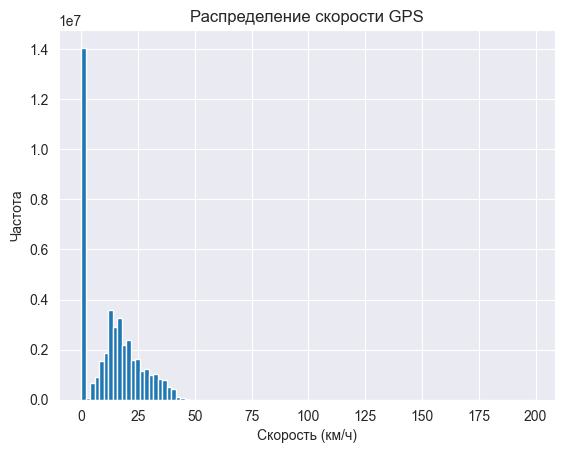

In [6]:
plt.hist(filtered_data['speed_gps'].dropna(), bins=100)
plt.title('Распределение скорости GPS')
plt.xlabel('Скорость (км/ч)')
plt.ylabel('Частота')
plt.grid(True)
plt.show()

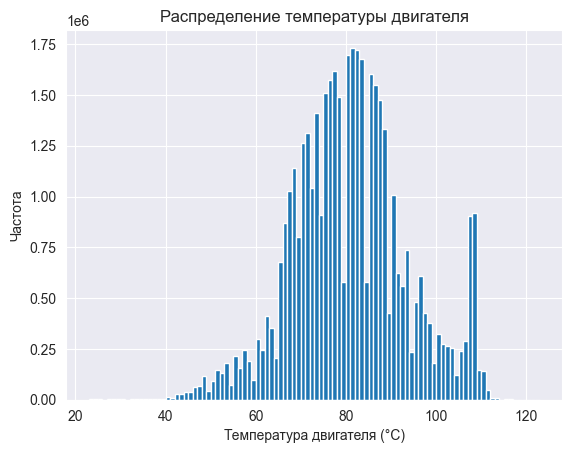

In [7]:
plt.hist(filtered_data['temp_engine'].dropna(), bins=100)
plt.title('Распределение температуры двигателя')
plt.xlabel('Температура двигателя (°C)')
plt.ylabel('Частота')
plt.grid(True)
plt.show()


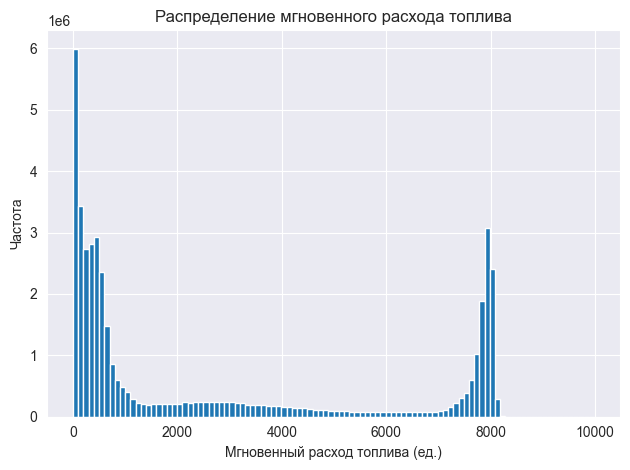

In [8]:
plt.hist(filtered_data['inst_fuel'].dropna(), bins=100)
plt.title('Распределение мгновенного расхода топлива')
plt.xlabel('Мгновенный расход топлива (ед.)')
plt.ylabel('Частота')
plt.grid(True)
plt.tight_layout()
plt.show()

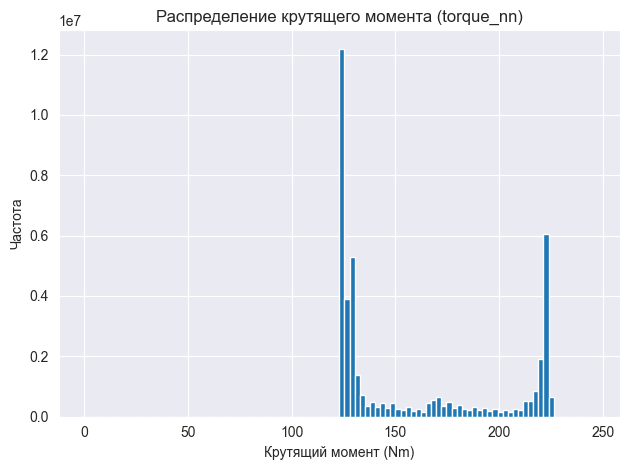

In [9]:
plt.hist(filtered_data['torque_nn'].dropna(), bins=100)
plt.title('Распределение крутящего момента (torque_nn)')
plt.xlabel('Крутящий момент (Nm)')
plt.ylabel('Частота')
plt.grid(True)
plt.tight_layout()
plt.show()

## Связь скорости и расхода топлива

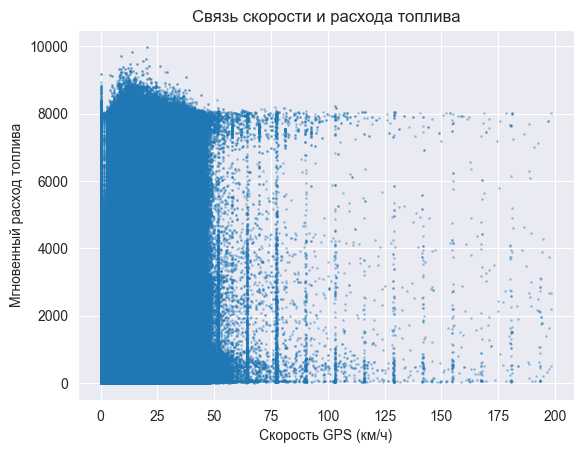

In [10]:
plt.scatter(
    filtered_data['speed_gps'],
    filtered_data['inst_fuel'],
    alpha=0.3,
    s=1  # маленький размер точки для снижения нагрузки
)
plt.title('Связь скорости и расхода топлива')
plt.xlabel('Скорость GPS (км/ч)')
plt.ylabel('Мгновенный расход топлива')
plt.grid(True)
plt.show()

## Анализ простоев
Считаем долю времени, когда самосвал стоит (скорость = 0), и строим топ-10 самых "стоячих" самосвалов.

In [11]:
stopped_ratio = (filtered_data['speed_gps'] == 0).mean()
print(f'Общая доля времени, когда самосвал стоял: {stopped_ratio:.2%}')

Общая доля времени, когда самосвал стоял: 32.09%


In [12]:
stopped_by_object = (
    filtered_data
    .groupby('mdm_object_id')['speed_gps']
    .apply(lambda x: (x == 0).mean())
    .reset_index(name='stopped_ratio')
)
stopped_by_object = stopped_by_object.sort_values(
    by='stopped_ratio', ascending=False
)
top_n = 10
print(f'\nТоп-{top_n} самосвалов по доле простоев:')
print(stopped_by_object.head(top_n))


Топ-10 самосвалов по доле простоев:
   mdm_object_id  stopped_ratio
3           1581          0.383
0           1381          0.350
5          21186          0.318
4           1661          0.306
2           1384          0.300
1           1383          0.292


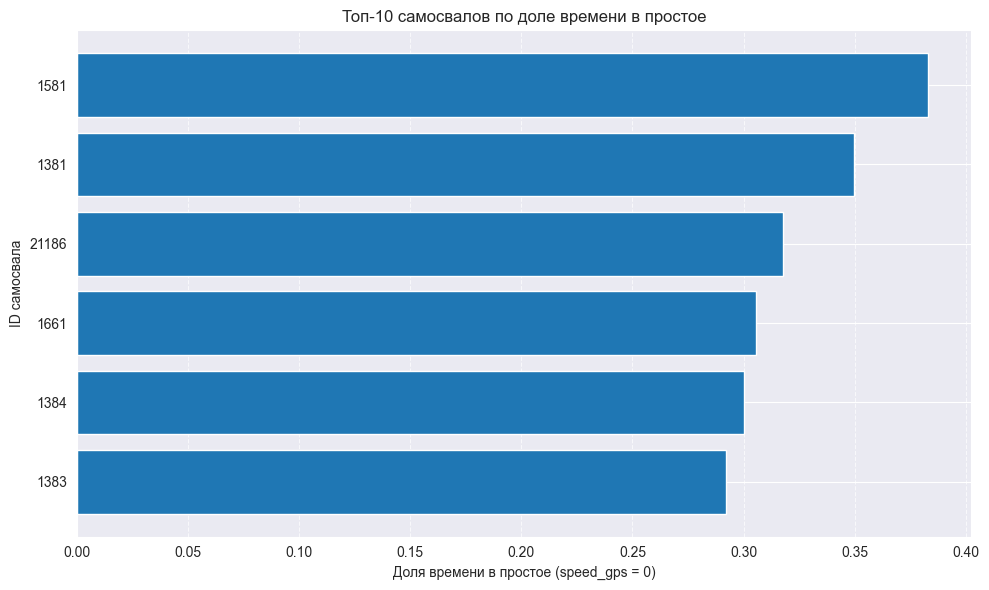

In [13]:
plt.figure(figsize=(10, 6))
plt.barh(
    stopped_by_object['mdm_object_id'].astype(str).head(top_n),
    stopped_by_object['stopped_ratio'].head(top_n)
)
plt.xlabel('Доля времени в простое (speed_gps = 0)')
plt.ylabel('ID самосвала')
plt.title(f'Топ-{top_n} самосвалов по доле времени в простое')
plt.gca().invert_yaxis()
plt.grid(axis='x', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()

## Временные ряды по отдельным самосвалам
Для каждого самосвала строим графики крутящего момента и температуры двигателя во времени (две оси Y). Для ускорения берём последние 5000 точек.

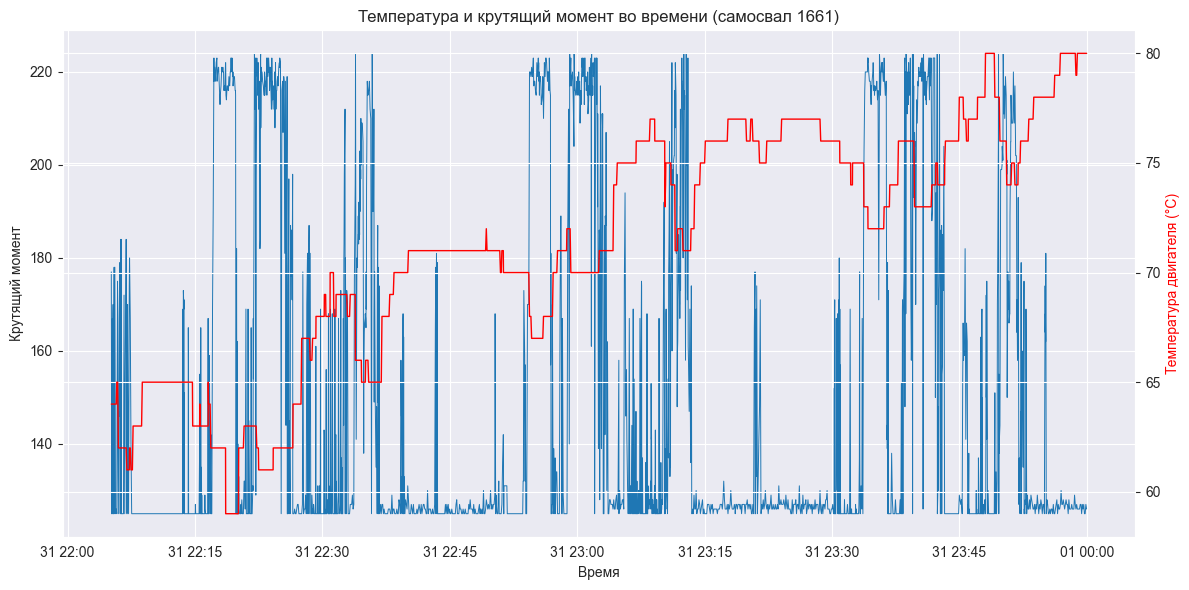

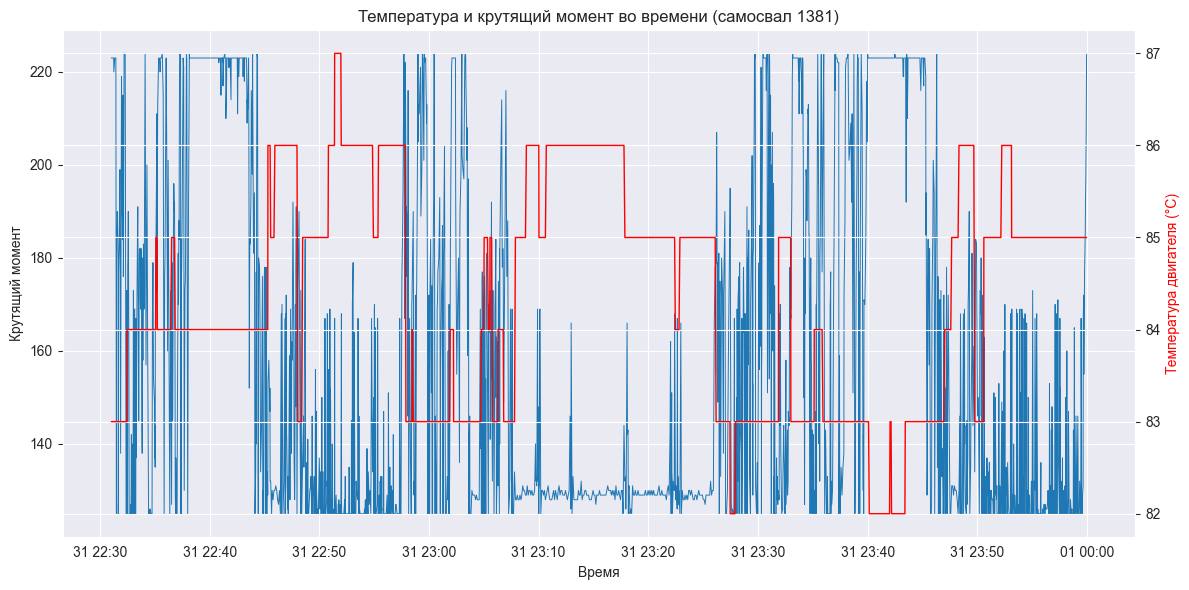

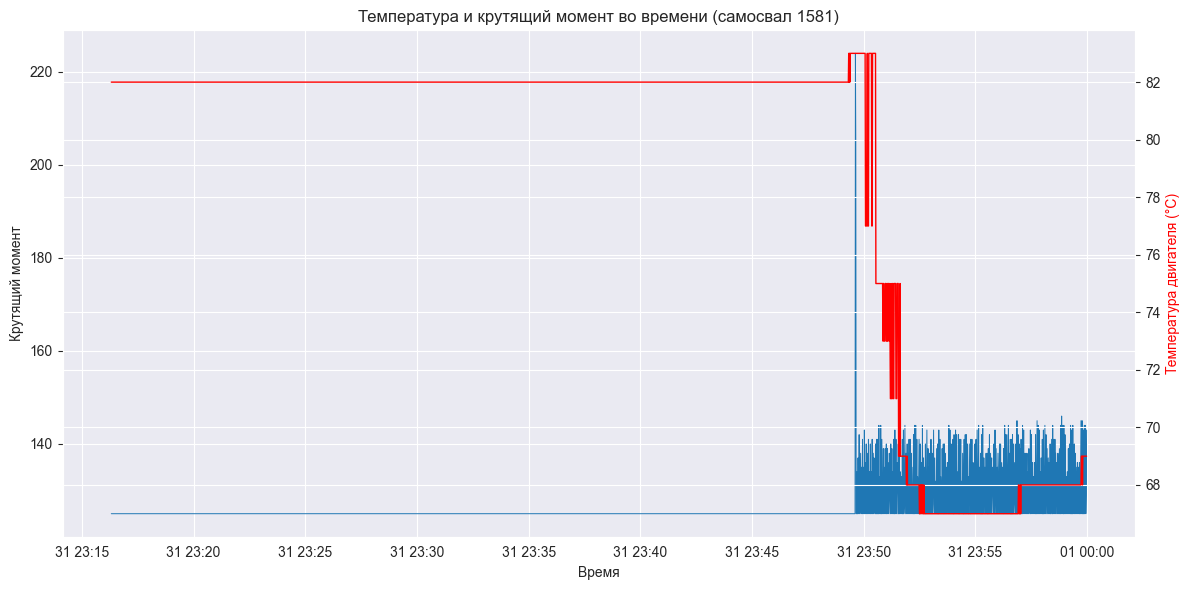

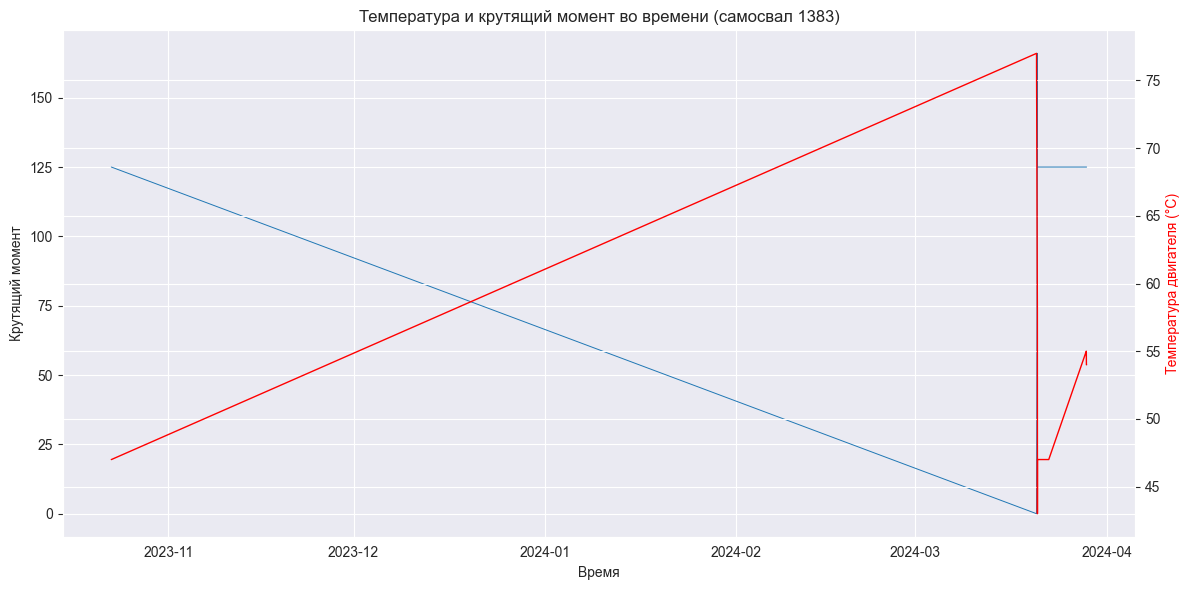

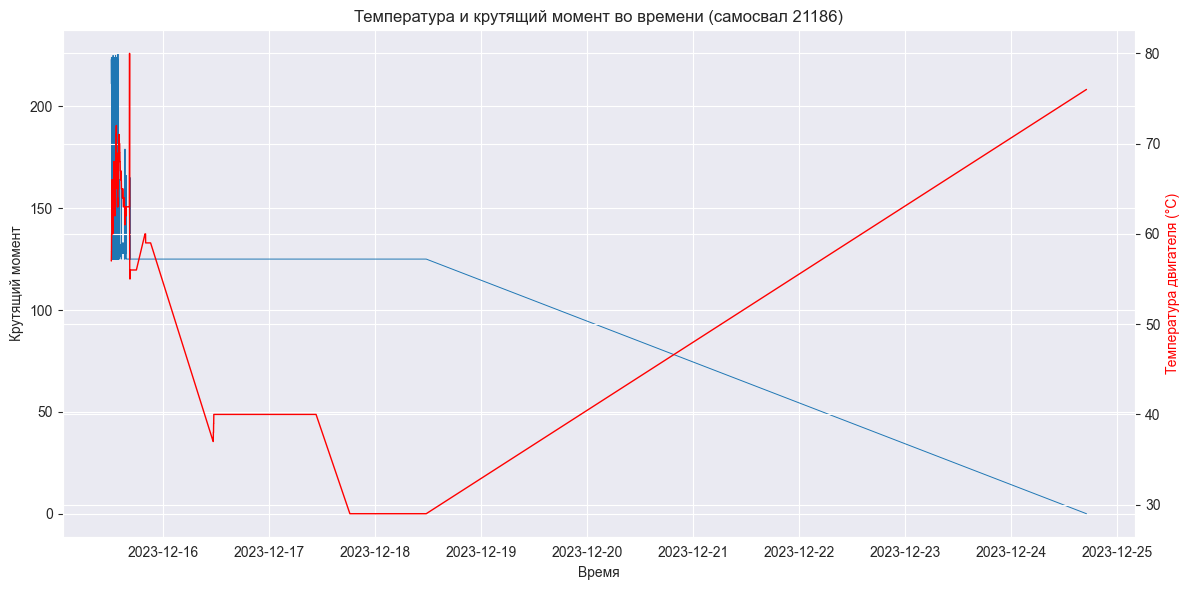

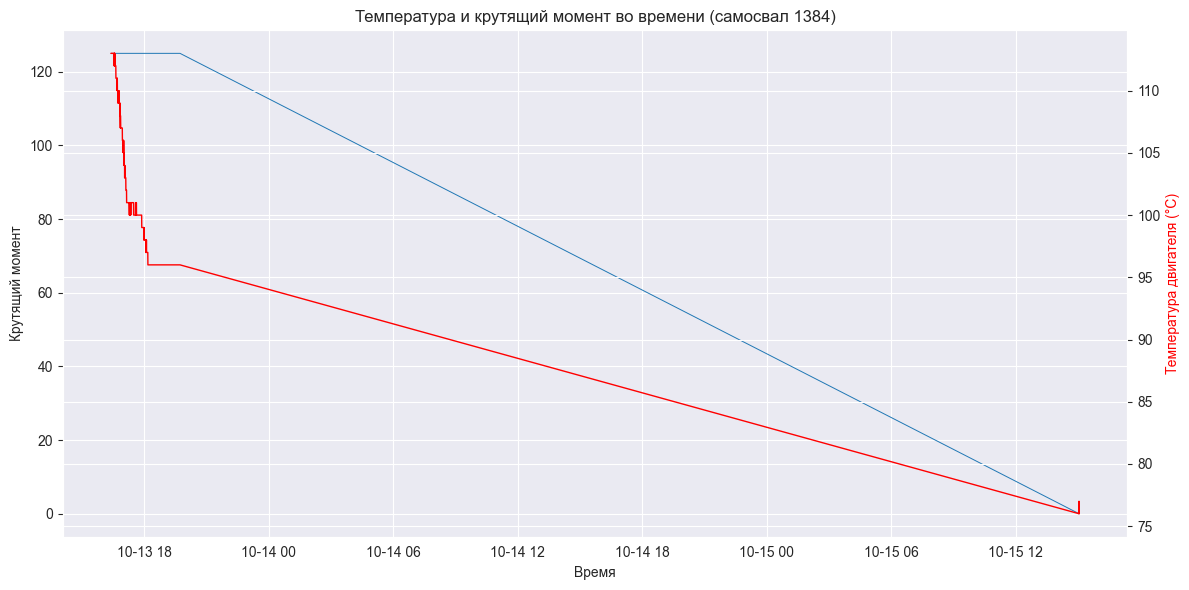

In [14]:
for truck in filtered_data['mdm_object_id'].unique():
    sample = filtered_data[filtered_data['mdm_object_id'] == truck].copy()
    sample['create_dt'] = pd.to_datetime(sample['create_dt'], errors='coerce')
    sample = sample.dropna(subset=['create_dt', 'torque_nn', 'temp_engine'])
    sample = sample.sort_values('create_dt')
    sample = sample.tail(5000)  # Для ускорения берём последние N строк

    if sample.empty:
        continue

    fig, ax1 = plt.subplots(figsize=(12, 6))
    ax1.plot(sample['create_dt'], sample['torque_nn'], label='Крутящий момент (Nm)', linewidth=0.7)
    ax1.set_xlabel('Время')
    ax1.set_ylabel('Крутящий момент')

    ax2 = ax1.twinx()
    ax2.plot(sample['create_dt'], sample['temp_engine'], color='red', label='Температура двигателя (°C)', linewidth=1)
    ax2.set_ylabel('Температура двигателя (°C)', color='red')

    plt.title(f'Температура и крутящий момент во времени (самосвал {truck})')
    fig.tight_layout()
    plt.grid(True)
    plt.show()